In [ ]:
from google.colab import drive
import os

drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks

os.chdir('./OCTA_CycleGAN/')

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
!pip install --upgrade pip
!pip uninstall scikit-image
!pip install scikit-image
import skimage
print(skimage.__version__)

     |████████████████████████████████| 1.7 MB 7.6 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
Found existing installation: scikit-image 0.18.3
Uninstalling scikit-image-0.18.3:
  Would remove:
    /usr/local/bin/skivi
    /usr/local/lib/python3.7/dist-packages/scikit_image-0.18.3.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scikit_image.libs/libgomp-3300acd3.so.1.0.0
    /usr/local/lib/python3.7/dist-packages/skimage/*
Proceed (Y/n)? y
  Successfully uninstalled scikit-image-0.18.3
     |████████████████████████████████| 13.3 MB 8.0 MB/s            
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.
0.19.1


In [ ]:
# Prepare package
!pip install lpips
!pip install scikit-learn
if not os.path.exists("./pytorch_wavelets"):
  !git clone https://github.com/fbcotter/pytorch_wavelets
%cd ./pytorch_wavelets/
!pip install .
%cd ../

     |████████████████████████████████| 53 kB 2.2 MB/s             
/content/drive/My Drive/Colab Notebooks/OCTA_CycleGAN/pytorch_wavelets
Processing /content/drive/My Drive/Colab Notebooks/OCTA_CycleGAN/pytorch_wavelets
  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-wavelets: filename=pytorch_wavelets-1.3.0-py3-none-any.whl size=54869 sha256=4a5049276903e4687a112855453f4b5daacd718308cd476798f24862d320471c
  Stored in directory: /tmp/pip-ephem-wheel-cache-vu9pxmdy/wheels/43/17/ca/1dc800811a84b5bf8928aaa3a5db728bd33939036a27e33048
Successfully built pytorch-wavelets
/content/drive/My Drive/Colab Notebooks/OCTA_CycleGAN


In [ ]:
import glob
import random
import os
from PIL import Image
import numpy as np
import time
import datetime
import sys

import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

from tensorflow import summary
from torch.utils.tensorboard import SummaryWriter

import argparse
import itertools
import matplotlib.pyplot as plt

from pytorch_wavelets import DWTForward

import pdb
import skimage.metrics

from tqdm import tqdm

import lpips
# loss_fn_alex = lpips.LPIPS(net='alex') # best forward scores
# loss_fn_vgg = lpips.LPIPS(net='vgg') # closer to "traditional" perceptual loss, when used for optimization

# import pytorch_fft.fft.autograd as fft

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('run_2/SR_baseline')

%load_ext tensorboard

In [ ]:
%tensorboard --logdir=run_2

In [ ]:
# Helper Functions
def tensor2image(tensor):
    image = 127.5*(tensor[0].cpu().float().numpy() + 1.0)
    if image.shape[0] == 1:
        image = np.tile(image, (3,1,1))
    return image.astype(np.uint8)


class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


In [ ]:
# Dataloader
class ImageDataset(Dataset):
    def __init__(self, root, transforms_A=None, transforms_B=None, unaligned=False, mode='train'):
        self.transformA = transforms.Compose(transforms_A)
        self.transformB = transforms.Compose(transforms_B)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, 'trainA') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, 'trainB') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        item_A = self.transformA(img_A)

        if self.unaligned:
            item_B = self.transformB(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('L'))
        else:
            item_B = self.transformB(Image.open(self.files_B[index % len(self.files_B)]).convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
class Discriminator(nn.Module):
    """Defines a PatchGAN discriminator"""

    def __init__(self, input_nc=1, ndf=64, n_layers=3, norm_layer=nn.BatchNorm2d):
        """Construct a PatchGAN discriminator

        Parameters:
            input_nc (int)  -- the number of channels in input images
            ndf (int)       -- the number of filters in the last conv layer
            n_layers (int)  -- the number of conv layers in the discriminator
            norm_layer      -- normalization layer
        """
        super(Discriminator, self).__init__()
        use_bias = True
        kw = 4
        padw = 1
        sequence = [nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw), nn.LeakyReLU(0.2, True)]
        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):  # gradually increase the number of filters
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=use_bias),
                norm_layer(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=use_bias),
            norm_layer(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]

        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]  # output 1 channel prediction map
        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        return self.model(input)

In [ ]:
def set_requires_grad(nets, requires_grad=False):
    """Set requies_grad=Fasle for all the networks to avoid unnecessary computations
    Parameters:
        nets (network list)   -- a list of networks
        requires_grad (bool)  -- whether the networks require gradients or not
    """
    if not isinstance(nets, list):
        nets = [nets]
    for net in nets:
        if net is not None:
            for param in net.parameters():
                param.requires_grad = requires_grad

In [ ]:
def save_sample(epoch, tensor, suffix="_real"):
    output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
    plt.imsave('./checkpoint_baseline_resnet/image_'+str(epoch+1)+suffix+'.jpeg', output, cmap="gray")

In [ ]:
#### Defination of local variables
input_nc = 1
output_nc = 1
batchSize = 1
size_A, size_B = 256, 256
lr = 2e-4
n_epochs, epoch, decay_epoch = 100, 0, 10
n_cpu = 2
dataroot = "./dataset/OCTA_baseline"
cuda = True

In [ ]:
if torch.cuda.is_available() and not cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [ ]:
class ResnetGenerator(nn.Module):
    """Resnet-based generator that consists of Resnet blocks between a few downsampling/upsampling operations.

    We adapt Torch code and idea from Justin Johnson's neural style transfer project(https://github.com/jcjohnson/fast-neural-style)
    """

    def __init__(self, input_nc=1, output_nc=1, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False, n_blocks=6, padding_type='reflect'):
        """Construct a Resnet-based generator

        Parameters:
            input_nc (int)      -- the number of channels in input images
            output_nc (int)     -- the number of channels in output images
            ngf (int)           -- the number of filters in the last conv layer
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers
            n_blocks (int)      -- the number of ResNet blocks
            padding_type (str)  -- the name of padding layer in conv layers: reflect | replicate | zero
        """
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()

        use_bias = False
        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        n_downsampling = 2
        for i in range(n_downsampling):  # add downsampling layers
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        mult = 2 ** n_downsampling
        for i in range(n_blocks):       # add ResNet blocks

            model += [ResnetBlock(ngf * mult, padding_type=padding_type, norm_layer=norm_layer, use_dropout=use_dropout, use_bias=use_bias)]

        for i in range(n_downsampling):  # add upsampling layers
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, int(ngf * mult / 2),
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1,
                                         bias=use_bias),
                      norm_layer(int(ngf * mult / 2)),
                      nn.ReLU(True)]
        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        """Standard forward"""
        return self.model(input)


class ResnetBlock(nn.Module):
    """Define a Resnet block"""

    def __init__(self, dim, padding_type, norm_layer=nn.BatchNorm2d, use_dropout=False, use_bias=False):
        """Initialize the Resnet block

        A resnet block is a conv block with skip connections
        We construct a conv block with build_conv_block function,
        and implement skip connections in <forward> function.
        Original Resnet paper: https://arxiv.org/pdf/1512.03385.pdf
        """
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, padding_type, norm_layer, use_dropout, use_bias)

    def build_conv_block(self, dim, padding_type, norm_layer, use_dropout, use_bias):
        """Construct a convolutional block.

        Parameters:
            dim (int)           -- the number of channels in the conv layer.
            padding_type (str)  -- the name of padding layer: reflect | replicate | zero
            norm_layer          -- normalization layer
            use_dropout (bool)  -- if use dropout layers.
            use_bias (bool)     -- if the conv layer uses bias or not

        Returns a conv block (with a conv layer, a normalization layer, and a non-linearity layer (ReLU))
        """
        conv_block = []
        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)

        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim), nn.ReLU(True)]
        if use_dropout:
            conv_block += [nn.Dropout(0.5)]

        p = 0
        if padding_type == 'reflect':
            conv_block += [nn.ReflectionPad2d(1)]
        elif padding_type == 'replicate':
            conv_block += [nn.ReplicationPad2d(1)]
        elif padding_type == 'zero':
            p = 1
        else:
            raise NotImplementedError('padding [%s] is not implemented' % padding_type)
        conv_block += [nn.Conv2d(dim, dim, kernel_size=3, padding=p, bias=use_bias), norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        """Forward function (with skip connections)"""
        out = x + self.conv_block(x)  # add skip connections
        return out

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [ ]:
###### Definition of variables ######
# Networks

netG_A2B = ResnetGenerator()
netG_B2A = ResnetGenerator()
netD_A = Discriminator()
netD_B = Discriminator()

if cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

netG_A2B.apply(weights_init_normal)
netG_B2A.apply(weights_init_normal)
netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
# criterion_phase = phase_consistency_loss()
criterion_identity = torch.nn.L1Loss()


# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(itertools.chain(netD_A.parameters(), netD_B.parameters()), lr=lr, betas=(0.5, 0.999))


lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
lr_scheduler_D = torch.optim.lr_scheduler.LambdaLR(optimizer_D, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor
input_A = Tensor(batchSize, input_nc, size_A, size_A)
# input_B = Tensor(batchSize, output_nc, size_A, size_A)
input_B = Tensor(batchSize, output_nc, size_B, size_B)
target_real = Variable(Tensor(batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

# Dataset loader
transforms_A = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)),
                # transforms.CenterCrop(size_A),
                transforms.RandomCrop((size_A, size_A))
                ]
                
transforms_B = [ 
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                # transforms.Normalize((0.286), (0.200)),
                # transforms.CenterCrop(size_B),
                transforms.RandomCrop((size_B, size_B))
                ]
dataset = ImageDataset(dataroot, transforms_A=transforms_A, transforms_B=transforms_B, unaligned=True)
print (len(dataset))
dataloader = DataLoader(dataset, batch_size=batchSize, shuffle=True)

# Loss plot
# logger = Logger(n_epochs, len(dataloader))
###################################


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.


354


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')

T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                 ])
T_2 = transforms.Compose([ transforms.ToTensor(),                         
                transforms.Normalize((0.5), (0.5))])

lr_img = T_1(lr_img).cuda().unsqueeze(0)
hr_img = T_2(hr_img).cuda().unsqueeze(0)

In [ ]:
def eval(model):
  lr = "./test/6x6_256/"
  hr = "./test/3x3_256/"
  num, psnr, ssim, mse, nmi= 0, 0, 0, 0, 0
  T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                 ])
  T_2 = transforms.Compose([ transforms.ToTensor(),                         
                  transforms.Normalize((0.5), (0.5))])
  for i in tqdm(range(297)):
    lr_path = os.path.join(lr, str(i)+"_3.png")
    hr_path = os.path.join(hr, str(i)+"_6.png")
    if os.path.isfile(lr_path) and os.path.isfile(hr_path):
      lr_img = Image.open(lr_path).convert('L')
      hr_img = Image.open(hr_path).convert('L')
      
      lr_img = T_1(lr_img).cuda().unsqueeze(0)
      hr_img = T_2(hr_img).cuda().unsqueeze(0)
      
      sr_img = model(lr_img)

      yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
      psnr += (skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
      ssim += (skimage.metrics.structural_similarity(yimg, gtimg))
      mse += (skimage.metrics.mean_squared_error(yimg, gtimg))
      nmi += (skimage.metrics.normalized_mutual_information(yimg, gtimg))
      num += 1
  print(" PSNR: %.4f SSIM: %.4f MSE: %.4f NMI: %.4f"%(psnr/num, ssim/num, mse/num, nmi/num))


In [ ]:
###### Training ######
globaliter = 0
for epoch in range(epoch, n_epochs):
    real_out, fake_out = None, None
    for i, batch in enumerate(dataloader):
        globaliter += 1
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ######### (1) forward #########
        fake_B = netG_A2B(real_A)
        recovered_A = netG_B2A(fake_B)
        fake_A = netG_B2A(real_B)
        recovered_B = netG_A2B(fake_A)


        ###### (2) G_A and G_B ######
        set_requires_grad([netD_A, netD_B], False)
        optimizer_G.zero_grad()

        pred_fake = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_fake, target_real)

        pred_fake = netD_A(fake_A)
        loss_GAN_B2A = criterion_GAN(pred_fake, target_real)

        idt_A = netG_A2B(real_B)
        loss_idt_B = criterion_identity(idt_A, real_B) * 0.5

        idt_B = netG_B2A(real_A)
        loss_idt_A = criterion_identity(idt_B, real_A) * 0.5
        

        loss_cycle_ABA = criterion_cycle(recovered_A, real_A)*10.0
        loss_cycle_BAB = criterion_cycle(recovered_B, real_B)*10.0

        loss_G = loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB + loss_idt_B + loss_idt_A

        loss_G.backward()        
        optimizer_G.step()

        ###### (3) D_A and D_B ######
        set_requires_grad([netD_A, netD_B], True)
        optimizer_D.zero_grad()

        # Real loss
        pred_real = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real, target_real)
        # Fake loss
        fake_A = fake_A_buffer.push_and_pop(fake_A)
        pred_fake = netD_A(fake_A.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)
        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()


        # Real loss
        pred_real = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real, target_real)      
        # Fake loss
        fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = netD_B(fake_B.detach())
        loss_D_fake = criterion_GAN(pred_fake, target_fake)
        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D.step()

        writer.add_scalar('GAN A2B loss', loss_GAN_A2B, globaliter)
        writer.add_scalar('GAN B2A loss', loss_GAN_B2A, globaliter)
        writer.add_scalar('Cycle ABA loss', loss_cycle_ABA, globaliter)
        writer.add_scalar('Cycle BAB loss', loss_cycle_BAB, globaliter)
        writer.add_scalar('Identity A loss', loss_idt_A, globaliter)
        writer.add_scalar('Identity B loss', loss_idt_B, globaliter)
        writer.add_scalar('Dis A loss', loss_D_A, globaliter)
        writer.add_scalar('Dis B loss', loss_D_B, globaliter)
        
        ####################################
        ####################################

        if i == 1:
          x = real_A.detach()
          real_out = x
          fake_out = netG_A2B(x)
      
    save_sample(epoch, real_out, "_input")
    save_sample(epoch, fake_out, "_output")

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D.step()



    # Save models checkpoints
    # torch.save(LR_encoding.state_dict(), 'output/LR_encoding.pth')
    if epoch%5==4:
      torch.save(netG_A2B.state_dict(), './baseline_output_resnet/netG_A2B_epoch'+str(epoch+1)+'.pth')
    print("Epoch (%d/%d) Finished" % (epoch+1, n_epochs))

    # sr_img = netG_A2B(lr_img)
    # LPIPS = loss_fn_alex(hr_img.cpu(), sr_img.cpu())

    # yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
    # hr_img_cpu = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
    # psnr = skimage.metrics.peak_signal_noise_ratio(yimg, hr_img_cpu)
    # ssim = skimage.metrics.structural_similarity(yimg, hr_img_cpu)

    # print(("PSNR: %.4f SSIM: %.4f LPIPS:"%(psnr, ssim)), LPIPS.data)

    # if epoch%3 == 0:
    eval(netG_A2B)

Epoch (1/100) Finished


100%|██████████| 297/297 [02:25<00:00,  2.04it/s]


 PSNR: 16.4467 SSIM: 0.4347 MSE: 0.0915 NMI: 1.0561
Epoch (2/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.80it/s]


 PSNR: 17.2198 SSIM: 0.4891 MSE: 0.0770 NMI: 1.0601
Epoch (3/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.72it/s]


 PSNR: 16.6888 SSIM: 0.4780 MSE: 0.0866 NMI: 1.0534
Epoch (4/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.84it/s]


 PSNR: 16.8258 SSIM: 0.4740 MSE: 0.0839 NMI: 1.0544
Epoch (5/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.66it/s]


 PSNR: 17.1207 SSIM: 0.4840 MSE: 0.0787 NMI: 1.0551
Epoch (6/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.06it/s]


 PSNR: 16.2390 SSIM: 0.4497 MSE: 0.0961 NMI: 1.0496
Epoch (7/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.86it/s]


 PSNR: 16.8244 SSIM: 0.4652 MSE: 0.0840 NMI: 1.0518
Epoch (8/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.82it/s]


 PSNR: 16.9632 SSIM: 0.4771 MSE: 0.0812 NMI: 1.0549
Epoch (9/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.71it/s]


 PSNR: 16.9074 SSIM: 0.4767 MSE: 0.0822 NMI: 1.0540
Epoch (10/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.35it/s]


 PSNR: 16.4238 SSIM: 0.4495 MSE: 0.0918 NMI: 1.0523
Epoch (11/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.49it/s]


 PSNR: 16.5270 SSIM: 0.4473 MSE: 0.0898 NMI: 1.0455
Epoch (12/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.43it/s]


 PSNR: 16.6383 SSIM: 0.4442 MSE: 0.0875 NMI: 1.0526
Epoch (13/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.66it/s]


 PSNR: 16.4811 SSIM: 0.4259 MSE: 0.0906 NMI: 1.0511
Epoch (14/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.49it/s]


 PSNR: 16.8016 SSIM: 0.4549 MSE: 0.0843 NMI: 1.0520
Epoch (15/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.42it/s]


 PSNR: 16.4056 SSIM: 0.4324 MSE: 0.0921 NMI: 1.0453
Epoch (16/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.85it/s]


 PSNR: 16.4479 SSIM: 0.4571 MSE: 0.0913 NMI: 1.0501
Epoch (17/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.79it/s]


 PSNR: 16.6349 SSIM: 0.4493 MSE: 0.0874 NMI: 1.0512
Epoch (18/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.88it/s]


 PSNR: 16.6197 SSIM: 0.4587 MSE: 0.0877 NMI: 1.0473
Epoch (19/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.50it/s]


 PSNR: 16.7258 SSIM: 0.4405 MSE: 0.0857 NMI: 1.0522
Epoch (20/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.53it/s]


 PSNR: 16.4265 SSIM: 0.4372 MSE: 0.0918 NMI: 1.0510
Epoch (21/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.55it/s]


 PSNR: 16.7543 SSIM: 0.4566 MSE: 0.0852 NMI: 1.0521
Epoch (22/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.79it/s]


 PSNR: 16.5564 SSIM: 0.4513 MSE: 0.0892 NMI: 1.0500
Epoch (23/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.59it/s]


 PSNR: 16.8389 SSIM: 0.4495 MSE: 0.0836 NMI: 1.0522
Epoch (24/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.67it/s]


 PSNR: 16.6222 SSIM: 0.4278 MSE: 0.0878 NMI: 1.0513
Epoch (25/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.78it/s]


 PSNR: 16.5962 SSIM: 0.4476 MSE: 0.0883 NMI: 1.0521
Epoch (26/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.19it/s]


 PSNR: 16.9160 SSIM: 0.4614 MSE: 0.0821 NMI: 1.0526
Epoch (27/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.95it/s]


 PSNR: 16.3809 SSIM: 0.4422 MSE: 0.0927 NMI: 1.0515
Epoch (28/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.15it/s]


 PSNR: 16.5167 SSIM: 0.4507 MSE: 0.0898 NMI: 1.0518
Epoch (29/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.96it/s]


 PSNR: 16.7844 SSIM: 0.4504 MSE: 0.0847 NMI: 1.0534
Epoch (30/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.61it/s]


 PSNR: 16.8158 SSIM: 0.4567 MSE: 0.0839 NMI: 1.0510
Epoch (31/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.36it/s]


 PSNR: 16.8118 SSIM: 0.4533 MSE: 0.0841 NMI: 1.0511
Epoch (32/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.18it/s]


 PSNR: 16.8434 SSIM: 0.4583 MSE: 0.0834 NMI: 1.0527
Epoch (33/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.14it/s]


 PSNR: 16.8312 SSIM: 0.4432 MSE: 0.0838 NMI: 1.0517
Epoch (34/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.02it/s]


 PSNR: 16.6649 SSIM: 0.4576 MSE: 0.0869 NMI: 1.0508
Epoch (35/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.89it/s]


 PSNR: 16.8350 SSIM: 0.4433 MSE: 0.0837 NMI: 1.0517
Epoch (36/100) Finished


100%|██████████| 297/297 [00:12<00:00, 24.71it/s]


 PSNR: 16.5187 SSIM: 0.4492 MSE: 0.0899 NMI: 1.0513
Epoch (37/100) Finished


100%|██████████| 297/297 [00:11<00:00, 24.80it/s]


 PSNR: 16.9582 SSIM: 0.4592 MSE: 0.0813 NMI: 1.0522
Epoch (38/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.85it/s]


 PSNR: 16.0511 SSIM: 0.4081 MSE: 0.1000 NMI: 1.0506
Epoch (39/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.72it/s]


 PSNR: 16.6672 SSIM: 0.4530 MSE: 0.0869 NMI: 1.0528
Epoch (40/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.57it/s]


 PSNR: 16.6790 SSIM: 0.4608 MSE: 0.0866 NMI: 1.0517
Epoch (41/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.84it/s]


 PSNR: 16.8734 SSIM: 0.4606 MSE: 0.0830 NMI: 1.0506
Epoch (42/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.89it/s]


 PSNR: 16.5888 SSIM: 0.4305 MSE: 0.0884 NMI: 1.0522
Epoch (43/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.63it/s]


 PSNR: 16.7525 SSIM: 0.4558 MSE: 0.0853 NMI: 1.0519
Epoch (44/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.90it/s]


 PSNR: 16.6642 SSIM: 0.4587 MSE: 0.0869 NMI: 1.0488
Epoch (45/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.46it/s]


 PSNR: 16.7272 SSIM: 0.4582 MSE: 0.0858 NMI: 1.0503
Epoch (46/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.92it/s]


 PSNR: 16.5928 SSIM: 0.4559 MSE: 0.0883 NMI: 1.0512
Epoch (47/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.06it/s]


 PSNR: 16.8879 SSIM: 0.4807 MSE: 0.0827 NMI: 1.0549
Epoch (48/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.01it/s]


 PSNR: 16.5534 SSIM: 0.4469 MSE: 0.0891 NMI: 1.0497
Epoch (49/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.20it/s]


 PSNR: 16.7521 SSIM: 0.4539 MSE: 0.0851 NMI: 1.0529
Epoch (50/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.25it/s]


 PSNR: 16.8473 SSIM: 0.4526 MSE: 0.0834 NMI: 1.0516
Epoch (51/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.32it/s]


 PSNR: 16.6090 SSIM: 0.4592 MSE: 0.0881 NMI: 1.0499
Epoch (52/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.12it/s]


 PSNR: 16.7136 SSIM: 0.4503 MSE: 0.0860 NMI: 1.0511
Epoch (53/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.24it/s]


 PSNR: 16.3642 SSIM: 0.4449 MSE: 0.0929 NMI: 1.0489
Epoch (54/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.10it/s]


 PSNR: 16.8067 SSIM: 0.4571 MSE: 0.0842 NMI: 1.0537
Epoch (55/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.75it/s]


 PSNR: 16.8145 SSIM: 0.4609 MSE: 0.0840 NMI: 1.0522
Epoch (56/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.36it/s]


 PSNR: 16.7570 SSIM: 0.4521 MSE: 0.0851 NMI: 1.0501
Epoch (57/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.03it/s]


 PSNR: 16.8238 SSIM: 0.4651 MSE: 0.0838 NMI: 1.0521
Epoch (58/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.17it/s]


 PSNR: 16.6227 SSIM: 0.4522 MSE: 0.0877 NMI: 1.0521
Epoch (59/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.01it/s]


 PSNR: 16.7739 SSIM: 0.4567 MSE: 0.0847 NMI: 1.0524
Epoch (60/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.84it/s]


 PSNR: 16.7568 SSIM: 0.4493 MSE: 0.0851 NMI: 1.0516
Epoch (61/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.13it/s]


 PSNR: 16.4547 SSIM: 0.4257 MSE: 0.0910 NMI: 1.0504
Epoch (62/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.33it/s]


 PSNR: 16.4983 SSIM: 0.4387 MSE: 0.0902 NMI: 1.0517
Epoch (63/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.21it/s]


 PSNR: 16.6118 SSIM: 0.4547 MSE: 0.0879 NMI: 1.0512
Epoch (64/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.73it/s]


 PSNR: 16.7606 SSIM: 0.4589 MSE: 0.0850 NMI: 1.0506
Epoch (65/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.55it/s]


 PSNR: 16.4628 SSIM: 0.4436 MSE: 0.0909 NMI: 1.0510
Epoch (66/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.65it/s]


 PSNR: 16.4254 SSIM: 0.4237 MSE: 0.0918 NMI: 1.0496
Epoch (67/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.69it/s]


 PSNR: 16.5261 SSIM: 0.4498 MSE: 0.0896 NMI: 1.0508
Epoch (68/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.47it/s]


 PSNR: 16.7798 SSIM: 0.4532 MSE: 0.0846 NMI: 1.0525
Epoch (69/100) Finished


100%|██████████| 297/297 [00:10<00:00, 27.05it/s]


 PSNR: 16.6273 SSIM: 0.4505 MSE: 0.0876 NMI: 1.0520
Epoch (70/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.67it/s]


 PSNR: 16.6841 SSIM: 0.4479 MSE: 0.0865 NMI: 1.0514
Epoch (71/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.83it/s]


 PSNR: 16.7100 SSIM: 0.4505 MSE: 0.0860 NMI: 1.0511
Epoch (72/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.36it/s]


 PSNR: 16.2715 SSIM: 0.4236 MSE: 0.0949 NMI: 1.0513
Epoch (73/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.87it/s]


 PSNR: 16.7146 SSIM: 0.4466 MSE: 0.0859 NMI: 1.0524
Epoch (74/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.54it/s]


 PSNR: 16.6731 SSIM: 0.4512 MSE: 0.0867 NMI: 1.0517
Epoch (75/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.44it/s]


 PSNR: 16.6976 SSIM: 0.4462 MSE: 0.0862 NMI: 1.0510
Epoch (76/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.54it/s]


 PSNR: 16.8482 SSIM: 0.4513 MSE: 0.0833 NMI: 1.0522
Epoch (77/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.24it/s]


 PSNR: 16.4976 SSIM: 0.4434 MSE: 0.0902 NMI: 1.0516
Epoch (78/100) Finished


100%|██████████| 297/297 [00:11<00:00, 25.74it/s]


 PSNR: 16.7541 SSIM: 0.4544 MSE: 0.0851 NMI: 1.0527
Epoch (79/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.69it/s]


 PSNR: 16.8217 SSIM: 0.4488 MSE: 0.0838 NMI: 1.0518
Epoch (80/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.27it/s]


 PSNR: 16.6528 SSIM: 0.4468 MSE: 0.0871 NMI: 1.0515
Epoch (81/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.61it/s]


 PSNR: 16.5446 SSIM: 0.4544 MSE: 0.0893 NMI: 1.0512
Epoch (82/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.48it/s]


 PSNR: 16.6775 SSIM: 0.4518 MSE: 0.0866 NMI: 1.0523
Epoch (83/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.82it/s]


 PSNR: 16.5947 SSIM: 0.4507 MSE: 0.0883 NMI: 1.0514
Epoch (84/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.81it/s]


 PSNR: 16.6448 SSIM: 0.4516 MSE: 0.0872 NMI: 1.0520
Epoch (85/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.27it/s]


 PSNR: 16.6876 SSIM: 0.4513 MSE: 0.0864 NMI: 1.0516
Epoch (86/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.49it/s]


 PSNR: 16.5919 SSIM: 0.4540 MSE: 0.0883 NMI: 1.0514
Epoch (87/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.04it/s]


 PSNR: 16.4700 SSIM: 0.4449 MSE: 0.0907 NMI: 1.0493
Epoch (88/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.56it/s]


 PSNR: 16.5939 SSIM: 0.4468 MSE: 0.0882 NMI: 1.0518
Epoch (89/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.87it/s]


 PSNR: 16.6885 SSIM: 0.4480 MSE: 0.0863 NMI: 1.0522
Epoch (90/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.40it/s]


 PSNR: 16.6627 SSIM: 0.4468 MSE: 0.0868 NMI: 1.0517
Epoch (91/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.68it/s]


 PSNR: 16.5554 SSIM: 0.4437 MSE: 0.0890 NMI: 1.0514
Epoch (92/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.84it/s]


 PSNR: 16.8208 SSIM: 0.4502 MSE: 0.0838 NMI: 1.0519
Epoch (93/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.55it/s]


 PSNR: 16.4827 SSIM: 0.4480 MSE: 0.0904 NMI: 1.0497
Epoch (94/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.77it/s]


 PSNR: 16.5239 SSIM: 0.4435 MSE: 0.0896 NMI: 1.0503
Epoch (95/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.69it/s]


 PSNR: 16.4847 SSIM: 0.4429 MSE: 0.0904 NMI: 1.0510
Epoch (96/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.48it/s]


 PSNR: 16.7084 SSIM: 0.4490 MSE: 0.0860 NMI: 1.0516
Epoch (97/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.38it/s]


 PSNR: 16.6965 SSIM: 0.4527 MSE: 0.0862 NMI: 1.0520
Epoch (98/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.48it/s]


 PSNR: 16.5542 SSIM: 0.4460 MSE: 0.0890 NMI: 1.0514
Epoch (99/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.76it/s]


 PSNR: 16.6852 SSIM: 0.4470 MSE: 0.0864 NMI: 1.0521
Epoch (100/100) Finished


100%|██████████| 297/297 [00:11<00:00, 26.62it/s]

 PSNR: 16.6854 SSIM: 0.4463 MSE: 0.0864 NMI: 1.0519


In [ ]:
def result_save_sample(epoch, tensor=None, suffix="_real", img=None, img_mode=False):
    if tensor != None:
      output = tensor.cpu().detach().numpy().squeeze(0).squeeze(0)
      plt.imsave('./results/image_baseline_resnet'+str(epoch)+suffix+'.jpeg', output, cmap="gray")
    if img_mode:
      plt.imsave('./results/image_baseline_resnet'+str(epoch)+suffix+'.jpeg', img, cmap="gray")

In [ ]:
netG_A2B = torch.load('./baseline_output_resnet/netG_A2B_epoch100.pth')
type(netG_A2B)
model = ResnetGenerator(output_nc, input_nc).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

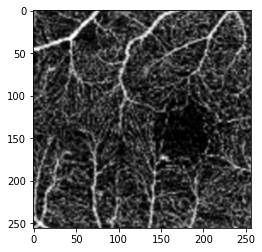

In [ ]:
img = dataset[0]['A']
x = img.unsqueeze(0).cuda()
plt.imshow(img.squeeze(0), "gray")
result_save_sample(1, tensor=x, suffix="_input")

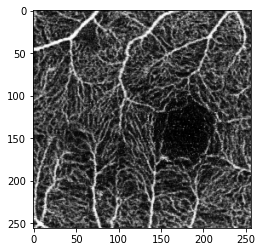

In [ ]:
y = model(x)
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")
result_save_sample(1, tensor=y, suffix="_output")

In [ ]:
import cv2
upsample = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(256, 256), interpolation=cv2.INTER_CUBIC)
upsample.shape
result_save_sample(1, img_mode=True, img=upsample, suffix="_interpolation")

(-0.5, 255.5, 255.5, -0.5)

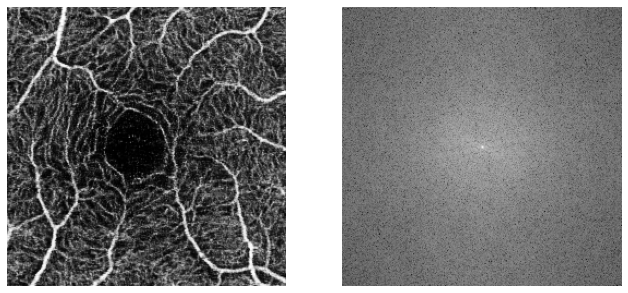

In [ ]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# img = x.cpu().detach().numpy().squeeze(0).squeeze(0)
img = y.cpu().detach().numpy().squeeze(0).squeeze(0)
f = np.fft.fft2(img, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(121), plt.imshow(img, 'gray')#, plt.title('Original Image')
plt.axis('off')
plt.subplot(122), plt.imshow(res, 'gray')#, plt.title('Fourier Amplitude')
plt.axis('off')
# plt.subplot(333), plt.imshow(pha, 'gray')#, plt.title('Fourier Phase')
# plt.axis('off')

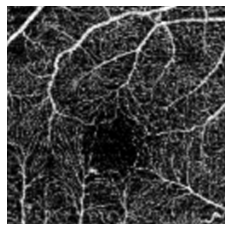

In [ ]:
img = dataset[0]['A']
x = img.unsqueeze(0).cuda()
plt.imshow(img.squeeze(0), "gray")
plt.axis('off')
y = model(x)

(-0.5, 255.5, 255.5, -0.5)

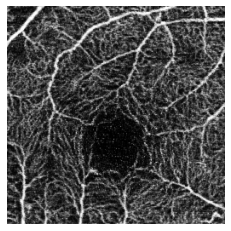

In [ ]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")
plt.axis('off')

In [ ]:
class Test_ImageDataset(Dataset):
    def __init__(self, root, transforms_test=None, unaligned=False, mode='test'):
        self.transformA = transforms.Compose(transforms_test)
        self.transformB = transforms.Compose(transforms_test)

        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '6x6_256/') + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '3x3_256/') + '/*.*'))

    def __getitem__(self, index):
        img_A = Image.open(self.files_A[index % len(self.files_A)]).convert('L')
        print(self.files_A[index % len(self.files_A)])
        item_A = self.transformA(img_A)

        item_B = self.transformB(Image.open("./test/3x3_256/102_6.png").convert('L'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
test_path = "./test/"
transforms_test = [ 
                transforms.ToTensor(),
                # transforms.Normalize((0.246), (0.170)),
                transforms.Normalize((0.5), (0.5)) ]
test_dataset = Test_ImageDataset(test_path, transforms_test=transforms_test, unaligned=True)

In [ ]:
import cv2
img = test_dataset[2]['A']
gt = test_dataset[2]['B']
print(img.shape)
# img = cv2.resize(img.squeeze(0).cpu().numpy(), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
x = torch.tensor(img).unsqueeze(0).cuda()
# plt.imshow(img.squeeze(0), "gray")
y = model(x)

./test/6x6_256/102_3.png
./test/6x6_256/102_3.png
torch.Size([1, 256, 256])


(-0.5, 255.5, 255.5, -0.5)

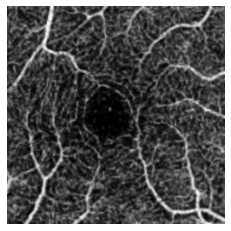

In [ ]:
plt.imshow(img.squeeze(0), "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

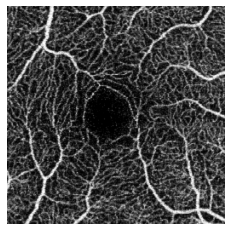

In [ ]:
plt.imshow(gt.squeeze(0), "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

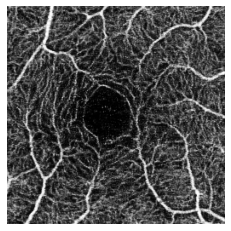

In [ ]:
yimg = y.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

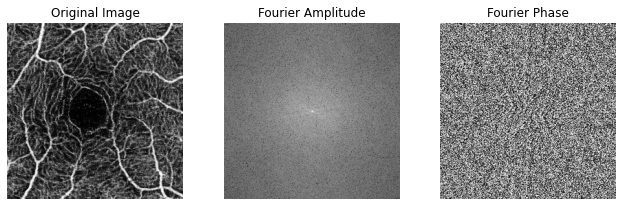

In [ ]:
f = np.fft.fft2(yimg, axes=(-2, -1))
fshift = np.fft.fftshift(f)
res = np.log(np.abs(fshift))
pha = np.angle(fshift)
plt.figure(figsize=(11, 11))
plt.subplot(331), plt.imshow(yimg, 'gray'), plt.title('Original Image')
plt.axis('off')
plt.subplot(332), plt.imshow(res, 'gray'), plt.title('Fourier Amplitude')
plt.axis('off')
plt.subplot(333), plt.imshow(pha, 'gray'), plt.title('Fourier Phase')
plt.axis('off')

Pick a pair of test data to evaluate

In [ ]:
netG_A2B = torch.load('./baseline_output_resnet/netG_A2B_epoch100.pth')
type(netG_A2B)
model = ResnetGenerator(output_nc, input_nc).cuda()
model.load_state_dict(netG_A2B, strict=False)

<All keys matched successfully>

In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
# lr_img = Image.open("./dataset/Colab_centered_OCTA/trainA/STDR403_20181029_101618_Angio (1)_R_001.png").convert('L')
# hr_img = Image.open("./dataset/Colab_centered_OCTA/trainB/STDR403_20181029_101802_Angio (1)_R_001.png").convert('L')
T_1 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5)),
                 ])
T_2 = transforms.Compose([ transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))])
# lr_img = cv2.resize(np.array(lr_img), dsize=(128, 128), interpolation=cv2.INTER_CUBIC)
# lr_img = torch.tensor(lr_img).unsqueeze(0).unsqueeze(0).cuda()
lr_img = T_1(lr_img).cuda().unsqueeze(0)
hr_img = T_2(hr_img).cuda().unsqueeze(0)
# lr_img.size()
sr_img = model(lr_img)

(256, 256)


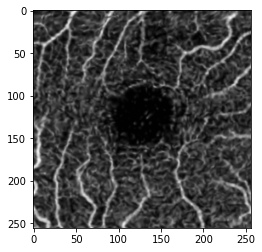

In [ ]:
ximg = lr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
print(ximg.shape)
plt.imshow(ximg, "gray")

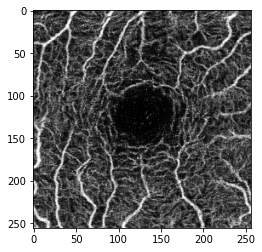

In [ ]:
yimg = sr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(yimg, "gray")

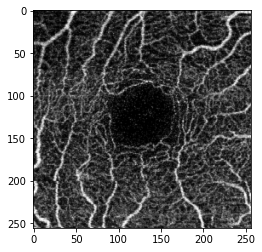

In [ ]:
gtimg = hr_img.cpu().detach().numpy().squeeze(0).squeeze(0)
plt.imshow(gtimg, "gray")

In [ ]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

17.09415439647993
0.45180391625504884


# Result

In [ ]:
import skimage.metrics
print(skimage.metrics.peak_signal_noise_ratio(yimg, gtimg))
print(skimage.metrics.structural_similarity(yimg, gtimg))

17.09415439647993
0.45180391625504884


In [ ]:
lr_img = Image.open("./test/6x6_256/270_3.png").convert('L')
hr_img = Image.open("./test/3x3_256/270_6.png").convert('L')
lr_img = T_1(lr_img)
hr_img = T_2(hr_img)

In [ ]:
input = lr_img.cuda().unsqueeze(0)
output = model(input)
# output = output.cpu().detach().numpy().squeeze(0).squeeze(0)